In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

# Feature Scaling
from sklearn.preprocessing import StandardScaler

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#import pandas_datareader.data as web
import datetime as dt

#from stockdata import prepare_stockdata

from stockcharts import plot_data


In [2]:
from stock_classifiers import stock_classifiers
#from stock_classification_drivers import classification_drivers

In [3]:
class prepare_stockdata: 
    def getstockdata(self,path):
        df = pd.read_csv(path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values(by=['Date'], inplace=True)
        df.index = df['Date']
        df = df.drop(['Date'], axis = 1)
        return df

    def getstockfeatures(self,df,features):
        df1 = pd.DataFrame(df[features])
        return df1

        
    def add_features(self,df):
        df['7DayAve'] = df['Close'].rolling(7).mean()
        df['15DayAve'] = df['Close'].rolling(15).mean()
        df["Day_Perc_Change"] = df["Close"].pct_change()*100
        #add support_resistance levels
        df = self.support_resistance(df)
        df.dropna(axis = 0, inplace = True)
        return df
    
    def support_resistance(self,data_ohlc):
        # Pivot Zone Calculation

        data_ohlc['Pivot'] = (data_ohlc["High"] + data_ohlc['Low'] + data_ohlc['Close'])/3
        data_ohlc['R1'] = (2 * data_ohlc['Pivot']) - data_ohlc['Low']
        data_ohlc['S1'] = (2 * data_ohlc['Pivot']) - data_ohlc['High']
        data_ohlc['R2'] = (data_ohlc['Pivot']) + (data_ohlc['High'] - data_ohlc['Low'])
        data_ohlc['S2'] = (data_ohlc['Pivot']) - (data_ohlc['High'] - data_ohlc['Low'])
        data_ohlc['R3'] = (data_ohlc['R1']) + (data_ohlc['High'] - data_ohlc['Low'])
        data_ohlc['S3'] = (data_ohlc['S1']) - (data_ohlc['High'] - data_ohlc['Low'])
        data_ohlc['R4'] = (data_ohlc['R3']) + (data_ohlc['R2'] - data_ohlc['R1'])
        data_ohlc['S4'] = (data_ohlc['S3']) - (data_ohlc['S1'] - data_ohlc['S2'])
        return data_ohlc


    #days_ahead can be set of -1 for next day prediction
    #df is the dataframe containing features
    def set_predictioncol(self,df,days_ahead):
        df['Prediction'] = df[['Close']].shift(days_ahead)
        return df

    def prepare_dataset(self,df,days_ahead):
        #Create a data set X and convert it into numpy array , which will be having actual values
        X = np.array(df.drop(['Prediction'],1))
        #Remove the last N rows

        X = X[:days_ahead]

        #print('X : \n',X)
        # Create a dataset y which will be having Predicted values and convert into numpy array
        y = np.array(df['Prediction'])
        # Remove Last 15 rows
        y = y[:days_ahead]
        #print(y)
        return X, y
    
    def preparation_driver(self,path,features,days_ahead):
        

        #Step 1 : Load Data
        df = self.getstockdata(path)


        #Step 2: Add relevant features
        df = self.add_features(df)
        
        #Step 3: Select relevant Features
        df = self.getstockfeatures(df,features)

        #Step 4: Setup/Create prediction column
        df = self.set_predictioncol(df,days_ahead)

        ##Step 5: Prepare dataset for classification
        X, y = self.prepare_dataset(df,days_ahead)

        #Step 6: Split the data into train and test with 90 & 10 % respectively
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        #To return X part of dataframe without movemnet
        #print(df.head())
        #df = df.drop(columns = ('Prediction','Close'),inplace=True)
        X_df = np.array(df.drop(['Close','Prediction'], axis = 1))

        return df,x_train, x_test, y_train, y_test,X_df


In [4]:
def support_resistance(data_ohlc):
    # Pivot Zone Calculation

    data_ohlc['Pivot'] = (data_ohlc['High'] + data_ohlc['Low'] + data_ohlc['Close'])/3
    data_ohlc['R1'] = (2*data_ohlc['Pivot']) - data_ohlc['Low']
    data_ohlc['S1'] = (2*data_ohlc['Pivot']) - data_ohlc['High']
    data_ohlc['R2'] = (data_ohlc['Pivot']) + (data_ohlc['High'] - data_ohlc['Low'])
    data_ohlc['S2'] = (data_ohlc['Pivot']) - (data_ohlc['High'] - data_ohlc['Low'])
    data_ohlc['R3'] = (data_ohlc['R1']) + (data_ohlc['High'] - data_ohlc['Low'])
    data_ohlc['S3'] = (data_ohlc['S1']) - (data_ohlc['High'] - data_ohlc['Low'])
    data_ohlc['R4'] = (data_ohlc['R3']) + (data_ohlc['R2'] - data_ohlc['R1'])
    data_ohlc['S4'] = (data_ohlc['S3']) - (data_ohlc['S1'] - data_ohlc['S2'])
    return data_ohlc
    

In [5]:
class classification_drivers:
    #def __init__(self):
    #    self.cls = stock_classifiers()
        
    def linearregression_driver(self,x_train,y_train,inp):
        cls = stock_classifiers()
        #Train the model
        lr = cls.linear_regression(x_train,y_train)
        #Evaluate the model performance
        cls.lr_score(lr,x_test,y_test)
        # Predict Next Day Value
        lr_pred = cls.model_prediction(lr,inp)
        #print("Linear Regression Predicted Next Day Value : ", lr_pred)
        return lr,lr_pred

    def randomforest_driver(self,x_train,x_test,inp):
        cls = stock_classifiers()
        # Feature scaling 
        sc,x_train_sc, x_test_sc = cls.feature_scaling(x_train,x_test)

        #Train the model
        rf = cls.random_forest(x_train_sc,y_train,40)

        #Evaluate the model performance
        cls.model_score(rf,x_test_sc,y_test)

        #Evaluate the model accuracy
        y_pred=rf.predict(x_test_sc)
        
        cls.model_error(y_test,y_pred)

        #Input scaling
        inp_sc = sc.transform(inp)

        # Prediction
        rf_pred = cls.model_prediction(rf,inp_sc)

        print("Predicted Next Day Value for Random Forest : ", rf_pred)

        return rf,rf_pred

    def decisiontree_driver(self,x_train,x_test,inp):    
        cls = stock_classifiers()
        #Train the model
        model = cls.decision_tree(x_train,y_train)
        #Evaluate the model performance
        cls.model_score(model,x_test,y_test)
        # Predict Next Day Value
        dt_pred = cls.model_prediction(model,inp)
        #print("Decision Tree Predicted Next Day Value : ", dt_pred)
        return model,dt_pred

    def lasso_driver(self, x_train,x_test,inp):    
        cls = stock_classifiers()
        #Train the model
        model = cls.lasso(x_train,y_train)
        #Evaluate the model performance
        cls.model_score(model,x_test,y_test)
        # Predict Next Day Value
        lasso_pred = cls.model_prediction(model,inp)
        #print("Lasso Predicted Next Day Value : ", lasso_pred)
        return model,lasso_pred

    def ridge_driver(self, x_train,x_test,inp):    
        cls = stock_classifiers()
        #Train the model
        model = cls.ridge(x_train,y_train)
        #Evaluate the model performance
        cls.model_score(model,x_test,y_test)
        # Predict Next Day Value
        ridge_pred = cls.model_prediction(model,inp)
        #print("Ridge Predicted Next Day Value : ", ridge_pred)
        return model,ridge_pred

    def cls_driver(self,x_train,y_train,inp):
        
        print("Linear Regression\n ")
        lr,lr_pred = self.linearregression_driver(x_train,y_train,inp)
        
        print("\nRandom Forest\n ")
        rf,rf_pred = self.randomforest_driver(x_train,x_test,inp)
        
        print("\nDecision Tree\n ")
        dt,dt_pred = self.decisiontree_driver(x_train,x_test,inp)

        print("\nLasso\n ")
        lasso_model,lasso_pred = self.lasso_driver(x_train,x_test,inp)

        print("\nRidge\n ")
        ridge_model,ridge_pred = self.ridge_driver(x_train,x_test,inp)

        val=[lr_pred,rf_pred,dt_pred,lasso_pred,ridge_pred]
        
        cols = ["Linear Regression","Random Forest","Decision Tree","Lasso","Ridge"]
        result = pd.DataFrame(val)
        result.index = cols
        result.columns = ["Predicted Value"]
        
        return result,lr,rf,dt,lasso_model,ridge_model


## Experiment

In [6]:
path = 'D:\\Stock Data\\TRG.csv'
#path = "D:\\Stock Data\\HUBC.csv"

features = ['LDCP','Close','R1','R2','R3','R4','S1','S2','S3','S4','7DayAve',
           '15DayAve','Day_Perc_Change']
days_ahead = -1
prp = prepare_stockdata()
df,x_train, x_test, y_train, y_test,X_df = prp.preparation_driver(path,features,days_ahead)
df.tail(10)


C:\Users\Hassan\AppData\Local\Temp/ipykernel_14044/2853212933.py:47: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df.drop(['Prediction'],1))


,LDCP,Close,R1,R2,R3,R4,S1,S2,S3,S4,7DayAve,15DayAve,Day_Perc_Change,Prediction
Date,,,,,,,,,,,,,,
2021-12-20,106.43,114.41,116.906667,119.403333,124.396667,126.893333,109.416667,104.423333,101.926667,96.933333,102.144286,93.808000,7.497886,116.24
2021-12-21,114.41,116.24,119.936667,123.633333,125.776667,129.473333,114.096667,111.953333,108.256667,106.113333,104.972857,95.748667,1.599511,117.53
2021-12-22,116.24,117.53,118.960000,120.390000,122.280000,123.710000,115.640000,113.750000,112.320000,110.430000,108.942857,97.694000,1.109773,124.35
2021-12-23,117.53,124.35,127.656667,130.963333,136.036667,139.343333,119.276667,114.203333,110.896667,105.823333,112.925714,100.535333,5.802774,118.40
2021-12-24,124.35,118.40,124.700000,131.000000,134.790000,141.090000,114.610000,110.820000,104.520000,100.730000,115.025714,103.238000,-4.784881,112.97
2021-12-27,118.40,112.97,116.800000,120.630000,122.860000,126.690000,110.740000,108.510000,104.680000,102.450000,115.761429,105.362667,-4.586149,118.21
2021-12-28,112.97,118.21,120.600000,122.990000,126.780000,129.170000,114.420000,110.630000,108.240000,104.450000,117.444286,107.431333,4.638400,121.13
2021-12-29,118.21,121.13,123.083333,125.036667,128.073333,130.026667,118.093333,115.056667,113.103333,110.066667,118.404286,109.259333,2.470180,121.13
2021-12-29,118.21,121.13,123.083333,125.036667,128.073333,130.026667,118.093333,115.056667,113.103333,110.066667,119.102857,110.998000,0.000000,125.01


In [7]:
#LDCP,7Day,15day,percentagechange
prev_inp = [[118.21,121.13,123.0833,125.0367,128.0733,130.026667,118.093333,115.0567,113.10,110.067,118,109,2.54]]
print(prev_inp)
clf = classification_drivers()
result,lr,rf,dt,lasso_model,ridge_model = clf.cls_driver(x_train,y_train,prev_inp)
#lasso,lasso_pred=lasso_driver(x_train,x_test,inp)
#print(lasso_pred)
print(result)

[[118.21, 121.13, 123.0833, 125.0367, 128.0733, 130.026667, 118.093333, 115.0567, 113.1, 110.067, 118, 109, 2.54]]
Linear Regression
 
Linear Regression Confidence :  0.9669661725669575

Random Forest
 
model confidence:  0.9607197875022907
Mean Absolute Error: 4.684548701298697
Mean Squared Error: 36.25264516152592
Root Mean Squared Error: 6.0210169540972
Predicted Next Day Value for Random Forest :  [122.655]

Decision Tree
 
model confidence:  0.9420995796079372

Lasso
 
model confidence:  0.9692277236120458

Ridge
 
model confidence:  0.967248758849033
                   Predicted Value
Linear Regression    -2.588366e+07
Random Forest         1.226550e+02
Decision Tree         1.211300e+02
Lasso                 1.217962e+02
Ridge                 1.220381e+02


In [8]:
print(df.tail(10))

              LDCP   Close          R1          R2          R3          R4  \
Date                                                                         
2021-12-20  106.43  114.41  116.906667  119.403333  124.396667  126.893333   
2021-12-21  114.41  116.24  119.936667  123.633333  125.776667  129.473333   
2021-12-22  116.24  117.53  118.960000  120.390000  122.280000  123.710000   
2021-12-23  117.53  124.35  127.656667  130.963333  136.036667  139.343333   
2021-12-24  124.35  118.40  124.700000  131.000000  134.790000  141.090000   
2021-12-27  118.40  112.97  116.800000  120.630000  122.860000  126.690000   
2021-12-28  112.97  118.21  120.600000  122.990000  126.780000  129.170000   
2021-12-29  118.21  121.13  123.083333  125.036667  128.073333  130.026667   
2021-12-29  118.21  121.13  123.083333  125.036667  128.073333  130.026667   
2021-12-30  121.13  125.01  128.826667  132.643333  135.306667  139.123333   

                    S1          S2          S3          S4     

In [9]:
sc = StandardScaler()
cls = stock_classifiers()
X_df_sc = sc.fit_transform(X_df)
rf_pred = cls.model_prediction(rf,X_df_sc)
dt_pred = cls.model_prediction(dt,X_df)
lasso_pred = cls.model_prediction(lasso_model,X_df)
ridge_pred = cls.model_prediction(ridge_model,X_df)
#print(rf_pred)
df['RandomForest'] = rf_pred
df['DecisionTree'] = dt_pred
df['Lasso'] = lasso_pred
df['Ridge'] = ridge_pred
df[['Close','Lasso','Ridge','RandomForest','DecisionTree','R2','S2']].tail(10)

ValueError: X has 12 features, but DecisionTreeRegressor is expecting 13 features as input.

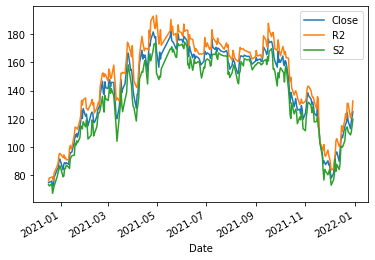

In [51]:
df[['Close','R2','S2']].plot()
plt.legend()

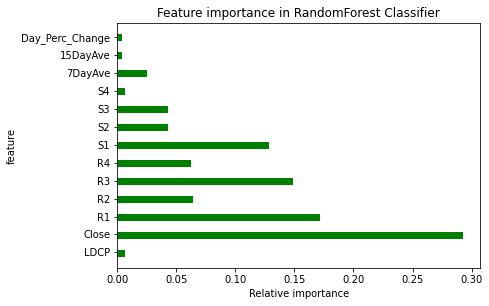

<Figure size 360x360 with 0 Axes>

In [31]:
#modelname.feature_importance_
y = rf.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/10)
col = ('LDCP','Close','R1','R2','R3','R4','S1','S2','S3','S4','7DayAve',
           '15DayAve','Day_Perc_Change')
ax.set_yticklabels(col, minor=False)
plt.title("Feature importance in RandomForest Classifier")
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

## Buying and Selling Levels

In [184]:
## Bullish Trend Analysis
df[['Close','R1','R2','R3','R4','S1','S2']].tail(5)

,Close,R1,R2,R3,R4,S1,S2
Date,,,,,,,
2021-12-23,124.35,127.656667,130.963333,136.036667,139.343333,119.276667,114.203333
2021-12-24,118.40,124.700000,131.000000,134.790000,141.090000,114.610000,110.820000
2021-12-27,112.97,116.800000,120.630000,122.860000,126.690000,110.740000,108.510000
2021-12-28,118.21,120.600000,122.990000,126.780000,129.170000,114.420000,110.630000
2021-12-29,121.13,123.083333,125.036667,128.073333,130.026667,118.093333,115.056667


In [185]:
## Bearish Trend analysis
df[['Close','R1','R2','S1','S2','S3','S4']].tail(5)

,Close,R1,R2,S1,S2,S3,S4
Date,,,,,,,
2021-12-23,124.35,127.656667,130.963333,119.276667,114.203333,110.896667,105.823333
2021-12-24,118.40,124.700000,131.000000,114.610000,110.820000,104.520000,100.730000
2021-12-27,112.97,116.800000,120.630000,110.740000,108.510000,104.680000,102.450000
2021-12-28,118.21,120.600000,122.990000,114.420000,110.630000,108.240000,104.450000
2021-12-29,121.13,123.083333,125.036667,118.093333,115.056667,113.103333,110.066667


In [53]:
levels = [80,120,140,160,180]
path = "D:\\Stock Data\\TRG.csv"
#path1 = "D:\\Stock Data\\HUBC.csv"

stock_plt = plot_data()

stock1 = stock_plt.load_stock_with_date(path)

stock1.head()

NameError: name 'stock_df' is not defined

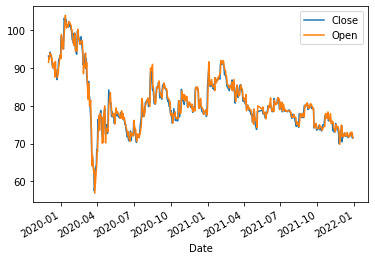

In [190]:
features = ['Close','Open']
stock_plt.plot_stock(stock1,features)

In [191]:
stock_plt.plot_candlestick(stock1,levels)

NameError: name 'stock' is not defined